In [1]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import urllib.request
from app.utils.dataset import DepthDataset, create_data_loader
from app.utils.env import Env
import matplotlib.pyplot as plt
import cv2

In [2]:
env = Env()

In [3]:

image_size = 256
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.ToPILImage()
])

target_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

dataset = DepthDataset(
    root_dir=env.dataset_path / "val",
    transform=transform,
    target_transform=target_transform,
)

dataloader = create_data_loader(
    dataset,
    batch_size=16,
    num_workers=4,
    shuffle=True
)

345

In [4]:
raw_image, depth_image = dataset[0]

In [5]:
type(raw_image)

PIL.Image.Image

In [6]:
raw_np = np.array(raw_image)

In [7]:
model_type = "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in C:\Users\mkami/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\mkami\AppData\Local\Programs\Python\Python313\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading weights:  None


Using cache found in C:\Users\mkami/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.small_transform

Using cache found in C:\Users\mkami/.cache\torch\hub\intel-isl_MiDaS_master


In [9]:
raw_np.shape

(256, 256, 3)

In [10]:
input_tensor = transform(raw_np).to(device)

In [11]:
input_tensor.shape

torch.Size([1, 3, 256, 256])

In [12]:
with torch.no_grad():
    prediction = midas(input_tensor)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=raw_np.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze().cpu().numpy()
    

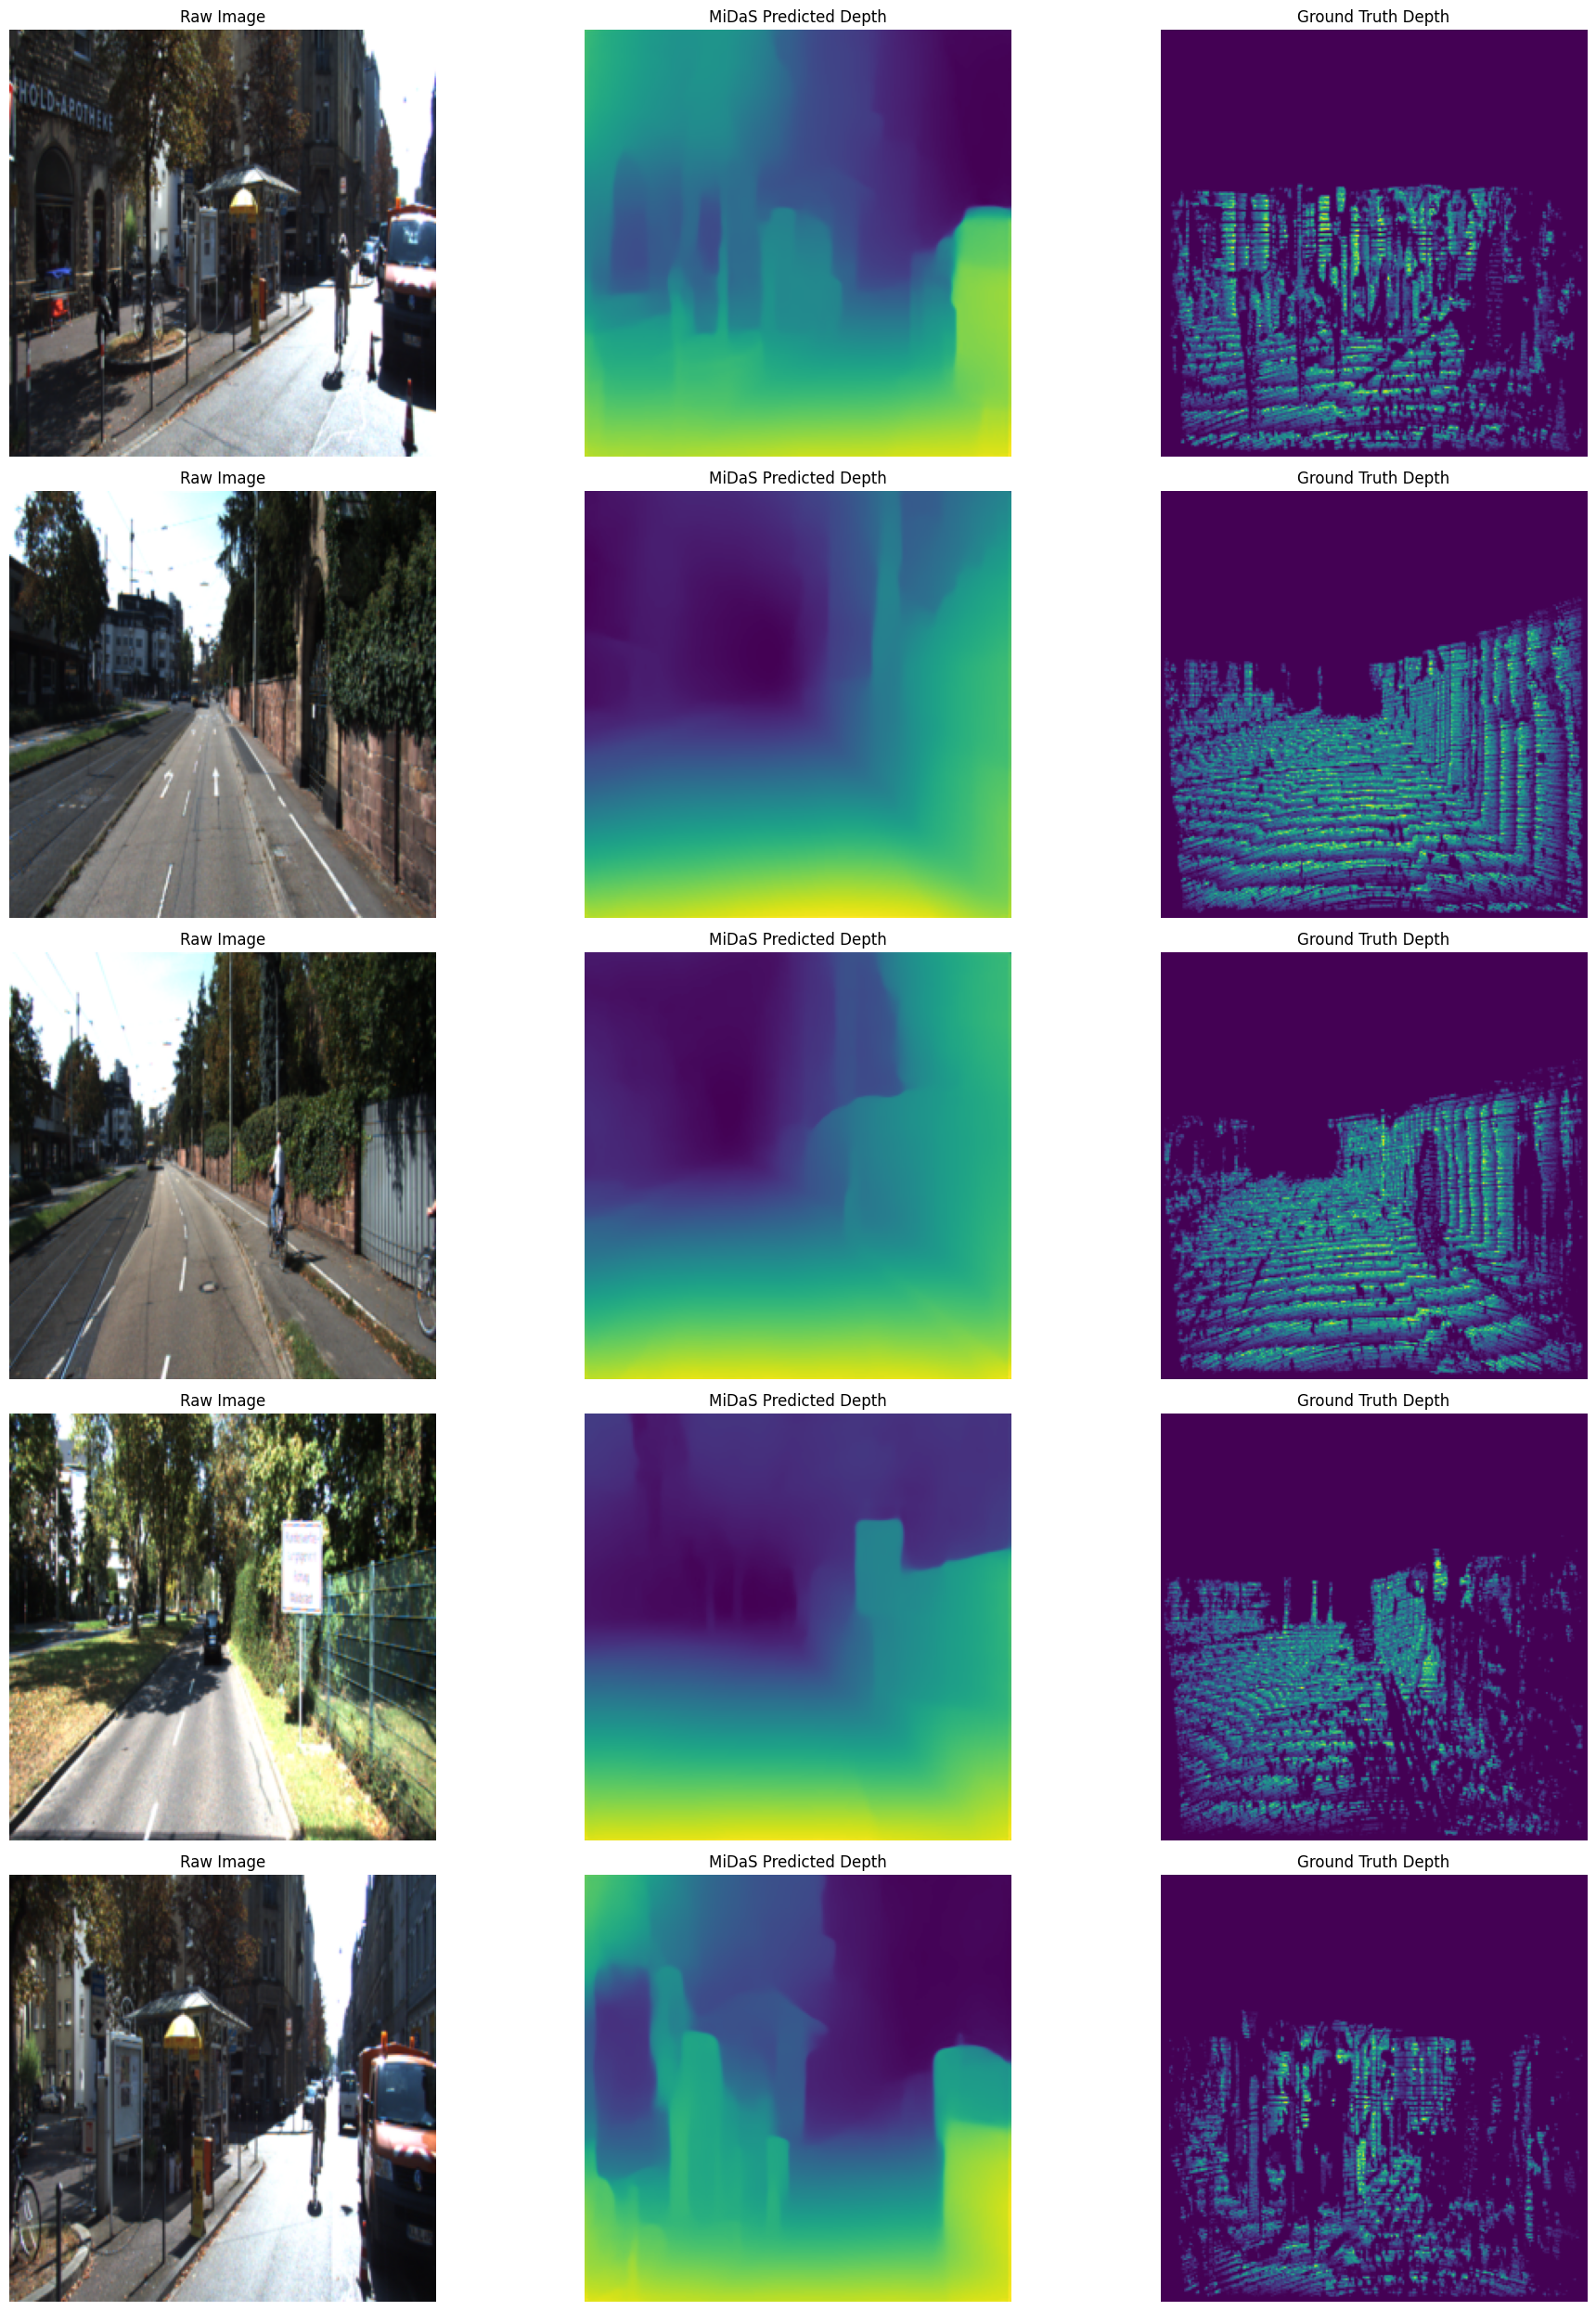

In [16]:
import random
random.seed(23)

num_examples = 5
fig = plt.figure(figsize=(20, 5*num_examples))

for i in range(num_examples):
    idx = random.randint(0, len(dataset)-1)
    raw_image, depth_image = dataset[idx]
    raw_np = np.array(raw_image)
    input_tensor = transform(raw_np).to(device)
    with torch.no_grad():
        prediction = midas(input_tensor)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=raw_np.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze().cpu().numpy()

    ax = fig.add_subplot(num_examples, 3, i*3+1)
    ax.imshow(raw_np)
    ax.set_title("Raw Image")
    ax.axis('off')

    ax = fig.add_subplot(num_examples, 3, i*3+2)
    ax.imshow(prediction)
    ax.set_title("MiDaS Predicted Depth")
    ax.axis('off')

    ax = fig.add_subplot(num_examples, 3, i*3+3)
    ax.imshow(depth_image.permute(1,2,0).numpy() * 255)
    ax.set_title("Ground Truth Depth")
    ax.axis('off')

plt.tight_layout()
plt.show()


    

    


# fig = plt.figure(figsize=(20, 5))
# ax = fig.add_subplot(1, 3, 1)
# ax.imshow(raw_np)
# ax = fig.add_subplot(1, 3, 2)
# ax.imshow(prediction)

# ax = fig.add_subplot(1, 3,3)
# ax.imshow(depth_image.permute(1,2,0).numpy() * 255)

# plt.show()

In [30]:
def scale_depth(pred, gt, mask):
    """
    Align predicted depth to ground truth using median scaling.
    """
    scale = np.median(gt[mask]) / np.median(pred[mask])
    return pred * scale


In [31]:
def compute_metrics(gt, pred, mask):
    """
    Compute standard depth metrics for evaluation.
    """
    thresh = np.maximum(gt[mask] / pred[mask], pred[mask] / gt[mask])
    a1 = (thresh < 1.25).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()
    abs_rel = np.mean(np.abs(gt[mask] - pred[mask]) / gt[mask])
    rmse = np.sqrt(np.mean((gt[mask] - pred[mask]) ** 2))
    log10 = np.mean(np.abs(np.log10(gt[mask]) - np.log10(pred[mask])))

    return {
        "AbsRel": abs_rel,
        "RMSE": rmse,
        "Log10": log10,
        "δ < 1.25": a1,
        "δ < 1.25^2": a2,
        "δ < 1.25^3": a3
    }


In [40]:
import numpy as np
def scale_invariant_log_error(y_true, y_pred) -> float:
    """
    Compute the scale-invariant log error used in on the KITTI dataset.
    y_true: ground truth values
    y_pred: predicted values

    Returns float: scale-invariant log error
    """

    # Convert to numpy arrays if they are not already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute the scale-invariant log error
    log_error = np.log(np.maximum(y_pred, 1e-6)) - np.log(np.maximum(y_true, 1e-6))
    n = len(y_true)
    
    sil_error = (np.sum(log_error ** 2) / n) - (np.sum(log_error) / n)**2
    return sil_error

In [42]:
scale_invariant_log_error(prediction, depth_image.permute(1,2,0).numpy())

np.float32(-364448870000.0)

In [ ]:
type(prediction), type(depth_image) 

(numpy.ndarray, torch.Tensor)